### Imports

In [ ]:
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import random
import os
import cv2
import sys
### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchvision.transforms import ToTensor, ToPILImage
%matplotlib inline

In [ ]:
from collections import defaultdict, deque
import datetime
import pickle
import time
import torch.distributed as dist
import errno

import collections
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image, ImageFile
import pandas as pd
from tqdm import tqdm
from torchvision import transforms
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.ops import boxes as bx
ImageFile.LOAD_TRUNCATED_IMAGES = True
CUDA_LAUNCH_BLOCKING = 1

In [ ]:
!git clone https://github.com/LucasGCardoso/TorchvisionObjectDetection

Cloning into 'TorchvisionObjectDetection'...
remote: Enumerating objects: 798, done.
remote: Total 798 (delta 0), reused 0 (delta 0), pack-reused 798
Receiving objects: 100% (798/798), 54.40 MiB | 23.63 MiB/s, done.
Resolving deltas: 100% (230/230), done.


In [ ]:
sys.path.append("TorchvisionObjectDetection")

In [ ]:
from engine import train_one_epoch, evaluate
import utils

### Prepare DataSet

In [ ]:

imgDir='./PNG'

annFile='./COCO/sub.json'

# Initialize the COCO api for instance annotations
coco=COCO(annFile)

# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(cats)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[{'supercategory': 'Caption', 'id': 1, 'name': 'Caption'}, {'supercategory': 'Footnote', 'id': 2, 'name': 'Footnote'}, {'supercategory': 'Formula', 'id': 3, 'name': 'Formula'}, {'supercategory': 'List-item', 'id': 4, 'name': 'List-item'}, {'supercategory': 'Page-footer', 'id': 5, 'name': 'Page-footer'}, {'supercategory': 'Page-header', 'id': 6, 'name': 'Page-header'}, {'supercategory': 'Picture', 'id': 7, 'name': 'Picture'}, {'supercategory': 'Section-header', 'id': 8, 'name': 'Section-header'}, {'supercategory': 'Table', 'id': 9, 'name': 'Table'}, {'supercategory': 'Text', 'id': 10, 'name': 'Text'}, {'supercategory': 'Title', 'id': 11, 'name': 'Title'}]


In [ ]:
print(coco)

In [ ]:
def getClassName(classID, cats):
    for i in range(len(cats)):
        if cats[i]['id']==classID:
            return cats[i]['name']
    return "None"


{'id': 26181, 'width': 1025, 'height': 1025, 'file_name': '6abd79e9c2f2373bb6cf2862cbaf33105159f72e1d74ee42213485efc7aa2d08.png', 'collection': 'arxiv_doublespaced', 'doc_name': '1004.4883.pdf', 'page_no': 24, 'precedence': 0, 'doc_category': 'scientific_articles'}
<class 'numpy.ndarray'>


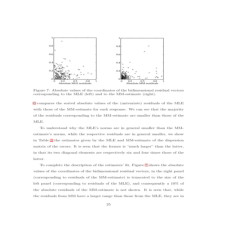

catIds [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
annIds [322892, 322893, 322894, 322895, 322896, 322897]
[{'id': 322892, 'image_id': 26181, 'category_id': 7, 'bbox': [195.79548344772067, 141.7934854376308, 546.4221470686389, 230.59840192279057], 'segmentation': [[195.79548344772067, 141.7934854376308, 195.79548344772067, 372.3918873604214, 742.2176305163596, 372.3918873604214, 742.2176305163596, 141.7934854376308]], 'area': 126004.07388924817, 'iscrowd': 0, 'precedence': 0}, {'id': 322893, 'image_id': 26181, 'category_id': 1, 'bbox': [124.03361344537817, 391.22083135391927, 707.9130802521009, 32.097777612826576], 'segmentation': [[124.03361344537817, 391.22083135391927, 124.03361344537817, 423.31860896674584, 831.9466936974791, 423.31860896674584, 831.9466936974791, 391.22083135391927]], 'area': 22722.436619142987, 'iscrowd': 0, 'precedence': 0}, {'id': 322894, 'image_id': 26181, 'category_id': 10, 'bbox': [124.03361344537817, 451.2598776722091, 708.0931357142857, 101.9246365795724], 'segmen

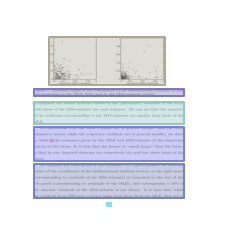

In [ ]:
catIds = coco.getCatIds() 
imgIds = coco.getImgIds()
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
print(img)
I = io.imread('PNG/{}'.format(img['file_name']))/255.0
print(type(I))
plt.axis('off')
plt.imshow(I)
plt.show()
# Load and display instance annotations
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
print("catIds", catIds)
print("annIds",annIds)
print(anns)
boxes = [ann['bbox'] for ann in anns]
print(boxes)
coco.showAnns(anns)

normal mask (1025, 1025)
(1025, 1025)


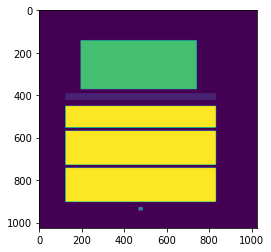

In [ ]:
#### GENERATE A SEGMENTATION MASK ####
Classes = [cat['name'] for cat in cats]
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = Classes.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
print("normal mask", mask.shape)
binary_mask = np.zeros((len(Classes),img['height'],img['width']))
for i in range(img['height']):
  for j in range(img['width']):
    binary_mask[int(mask[i,j]),i,j]=1 
print(mask.shape)
plt.imshow(mask)

In [ ]:
class DocLayNetDataset(torch.utils.data.Dataset):
      def __init__(self, imgDir, annotFile):
        self.height = 256
        self.width = 256
        self.imgDir = imgDir
        self.annotations = COCO(annotFile)
        self.imgIDs = self.annotations.getImgIds()
        self.catIDs = self.annotations.getCatIds()
        self.cats = self.annotations.loadCats(self.catIDs)

      def __getitem__(self, index):
        id = self.imgIDs[index]
        #print("id", id)
        img = self.annotations.loadImgs(id)[0]
        #print(img)
        I = io.imread(imgDir+'/'+img['file_name'])/255.0
        #plt.axis('off')
        #plt.imshow(I)
        #plt.show()
        annIds = self.annotations.getAnnIds(id, self.catIDs, iscrowd=None)
        #print("self.cats", self.cats)
        #print("annIds",annIds)
        #print("self.annotations",self.annotations)
        anns = self.annotations.loadAnns(annIds)
        #print("anns", anns)
        boxes = [ann['bbox'] for ann in anns]
        labels = [ann['category_id'] for ann in anns]
        areas = [ann['area'] for ann in anns]
        iscrowds = [ann['iscrowd'] for ann in anns]
        classes = [cat['name'] for cat in self.cats]
        #binary mask [N,H,W] N number of instances
        normal_mask = np.zeros((img['height'],img['width']))
        for i in range(len(anns)):
          className = getClassName(anns[i]['category_id'], self.cats)
          pixel_value = classes.index(className)+1
          normal_mask = np.maximum(self.annotations.annToMask(anns[i])*pixel_value, normal_mask)
        #print("normal mask", normal_mask.shape)
        
        binary_mask = np.zeros((len(classes),img['height'],img['width']))
        for i in range(img['height']):
          for j in range(img['width']):
            binary_mask[int(normal_mask[i,j]),i,j]=1
        #print("binary mask", binary_mask.shape)

        boxes_tr = torch.as_tensor(np.asarray(boxes), dtype=torch.float32)
        #print("boxes_tr", boxes)
        labels_tr = torch.as_tensor(labels, dtype=torch.int64)
        #print("labels_tr", labels_tr)
        masks_tr = torch.as_tensor(binary_mask, dtype=torch.uint8)
        #print("masks_tr", masks_tr)
        areas_tr = torch.as_tensor(areas, dtype=torch.float32)
        iscrowds_tr = torch.as_tensor(iscrowds, dtype=torch.uint8)
        target = {}
        target['boxes'] = bx.box_convert(boxes_tr, 'xywh', 'xyxy')
        target['labels']= labels_tr
        target['masks'] = masks_tr
        target['image_id'] = torch.as_tensor(id, dtype=torch.int64)
        target['area'] = areas_tr
        target['iscrowd'] = iscrowds_tr

        I = np.transpose(I, [2,0,1])
        img = torch.tensor(I).float()
        img = img.cuda()
        return img, target


      def __len__(self):
        return len(self.imgIDs)

In [ ]:
dataSet = DocLayNetDataset('PNG', 'COCO/sub.json')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(3, 1025, 1025)


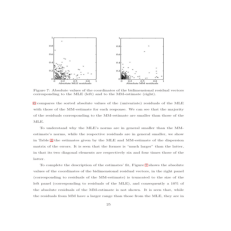

In [ ]:
image = dataSet[0][0].cpu().detach().numpy()
print(image.shape)
image = np.transpose(image, [1,2,0])
plt.axis('off')
plt.imshow(image)
plt.show()

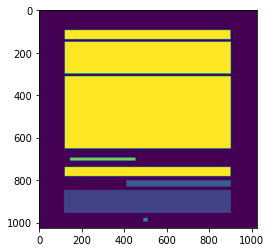

In [ ]:
m = dataSet[1][1]['masks'].cpu().detach().numpy()
#print(m)

#m = np.transpose(m, [1,2,0])
new_mask = np.zeros((m.shape[1],m.shape[2]))
for i in range(m.shape[1]):
  for j in range(m.shape[2]):
    new_mask[i,j] = np.argmax(m[:,i,j])
#print(new_mask)
plt.imshow(new_mask)
#"""

In [ ]:
dataSet[1][1]['area']

tensor([ 33184.5039, 117734.7188, 265822.4375,   4358.4463,  33193.5000,
         14216.8623,  84792.3281,    304.1705])

In [ ]:
print(dataSet[1][1]['boxes'])

### Data Loader

In [ ]:
data_loader = torch.utils.data.DataLoader(dataSet, batch_size=1, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

### MODEL

In [ ]:
num_classes=11
# load an instance segmentation model pre-trained pre-trained on COCO
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
hidden_layer = 256
    # and replace the mask predictor with a new one
model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)


### Training

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)
    # and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=3,
                                                   gamma=0.1)

    # let's train it for 10 epochs
num_epochs = 10

In [ ]:
#model.cuda()

In [ ]:
CUDA_LAUNCH_BLOCKING=1

In [ ]:
for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=1)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader, device=device)

RuntimeError: ignored

In [ ]:
def convert_tensor_to_RGB(network_output):
   
    converted_tensor = torch.squeeze(network_output)

    return converted_tensor

In [ ]:
print("###### Running the model ######")
model.eval()
model.cuda()
image, target = dataSet[1]
print(image.shape)

plt.axis('off')
plt.imshow(torch.transpose(image,0,2).cpu())
plt.show()
#Here we create a list, because the model expects a list of Tensors
lista = [image]
#It is important to send the image to CUDA, otherwise it will try to execute in the CPU
#x = image[0][0].cuda()
#lista.append(x)

output = model(lista)
print(output[0].keys())

labels = masks = output[0]['labels']
print(labels)
masks = output[0]['masks']
scores = output[0]['scores']
print(scores)
print(masks.shape)
print("### Converting output to RGB ###")
output = convert_tensor_to_RGB(output[0].get('masks'))
print(output.shape)
    #Here, we pass the output to CPU in order to properly save the image
output_cpu = output.cpu()
print(output_cpu.shape)
    #Just a number to order your images
number = 3

    #Saving the images
ToPILImage()(output_cpu[0:3,:,:]).save(str(number)+'.png', mode='png')
print("#### All Done! :) ####")

### Big Training

In [ ]:
!wget https://codait-cos-dax.s3.us.cloud-object-storage.appdomain.cloud/dax-doclaynet/1.0.0/DocLayNet_core.zip

In [ ]:
!unzip DocLayNet_core.zip

In [ ]:
TraindataSet = DocLayNetDataset('PNG', 'COCO/train.json')

loading annotations into memory...
Done (t=13.97s)
creating index...
index created!


In [ ]:
data_loader_train = torch.utils.data.DataLoader(TraindataSet, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

In [ ]:
model.cuda()
for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=1)
        # update the learning rate
        lr_scheduler.step()
        # evaluate on the test dataset
        evaluate(model, data_loader_train, device=device)

Epoch: [0]  [    0/17344]  eta: 1 day, 22:06:46  lr: 0.000010  loss: 12.5825 (12.5825)  loss_classifier: 2.4089 (2.4089)  loss_box_reg: 0.0438 (0.0438)  loss_mask: 0.8761 (0.8761)  loss_objectness: 8.2256 (8.2256)  loss_rpn_box_reg: 1.0281 (1.0281)  time: 9.5714  data: 2.2480  max mem: 3261


FileNotFoundError: ignored